## Trabajo final minería de datos
### Clasificación de covid

## Índice

- [Dependencias](#Dependencias)
- [Selección del problema y motivacion](#Seleccion-del-problema-y-motivacion)
- [Objetivo](#Objetivo)
- [Descripción de los datos](#Descripción-de-los-datos)
- [Limpieza del dataset](#Limpieza-del-dataset)
- [Evaluación](#Evaluación)
- [Conjuntos train/val/test](#Conjuntos-train/val/test)
- [Selección de variables](#Selección-de-variables)
- [Selección de instancias](#Selección-de-instancias)
- [Arbol de decisión](#Arbol-de-decisión)
- [Bosque](#Bosque)
- [Adaboost](#Adaboost)

### Dependencias

In [1]:
import data_preprocessing as dp
import variable_selection as vs
import instance_selection as i_sel
import classification_models as cm

import numpy as np
from sklearn import model_selection, feature_selection, tree

### Seleccion del problema y motivacion

Determinar si una persona tiene o no covid a partir de 9 preguntas de sí o no como tos, fiebre, edad, dolor de garganta...

El covid-19 es tema de actualidad muy interesante y una buena forma de aplicar la minería de datos para resolver un problema real, el objetivo será máximizar al máximo el porcentaje de acierto tanto de positivos y negativos con un mecanismo más barato en innvador que las actuales pruebas de antígenos.

### Objetivo

Tras realizar ciertas investigaciones sobre la efectividad de las pruebas de antígenos, según fuentes como Reacción médica o College of american pathologists, estas pruebas rondan el 80% de sensibilidad y el 98% de especificidad, partiendo de la idea de que no es realista mejorar estos objetivos mediante un modelo de predicción, el objetivo será acercarse al máximo a estos porcentajes e intentar competir con los mismos.

### Descripción de los datos

Nos encontramos frente a un dataset muy extenso que inicialmente contaba con más de 270.000 intancias, debido a los problemas computacionales que supone tratar un dataset tan amplio, se procedió a realizar una reduccíon del dataset del 95%, de este modo el dataset reducido cuenta con 13.500 intancias de las cuales 12630 son negativas y 704 positivas. Se observa que el dataset está claramente desbalanceado (95% negativos frente a un 5% de positivos) por lo que las técnicas aplicadas a lo largo de la minería de datos tendrán que ir adaptandose a esta condición

In [2]:
#Fijar semilla aleatoria para reproducir experimentos
np.random.seed(12)

X, y = dp.read_data('corona_data_reduced_95.csv', verbose=True)

corona_data_reduced_95.csv info:
Instances: 13500
Variables: 9

negative instances: 12630
positive instances: 704
other instances: 166
Dtypes: 
test_date               object
cough                  float64
fever                  float64
sore_throat              int64
shortness_of_breath      int64
head_ache                int64
age_60_and_above        object
gender                  object
test_indication         object
dtype: object
corona_result    object
dtype: object

Missing values: 
test_date                 0
cough                    10
fever                    10
sore_throat               0
shortness_of_breath       0
head_ache                 0
age_60_and_above       6330
gender                  577
test_indication           0
dtype: int64
corona_result    0
dtype: int64


Las instancias se caracterizan por 9 variables:

- Fecha → Numérica
    - Valores: Fecha → 02/09/20
- Tos → Categórica
    - Valores: Si / No
- Fiebre → Categórica
    - Valores: Si / No
- Dolor de garganta → Categórica
    - Valores: Si / No
- Dificultad para respirar → Categórica
    - Valores: Si / No
- Dolor de cabeza → Categórica
    - Valores: Si / No
- Edad por encima de los 60 años → Categórica Si/No
    - Valores: Si / No
- Género
    - Valores: Maculino / Femenino
- Contacto con positivo:
    - Valores: Si / No / Nsnc

### Limpieza del dataset

In [3]:
X, y = dp.clean_data_output(X, y)
X, y = dp.impute_data_na(X, y)
X = dp.encode_categorical(X, y)


Unique output variables: ['negative' 'positive' 'other']
Cleaning 166 instances of "other" corona results...

Imputing missing values by most frequent...

impute_data_na took 0.10299921035766602[s] to execute.

Encoding categorical variables...


test_date values: [0.01542416 0.01357466 0.02240896 0.01944444 0.01060071 0.01945525
 0.01939058 0.03938731 0.015625   0.03198294 0.02692998 0.02325581
 0.0273224  0.02313625 0.01662708 0.03206997 0.08641975 0.04825737
 0.07037037 0.04901961 0.08171206 0.06465517 0.07100592 0.06060606
 0.06130268 0.06020942 0.0825     0.06888361 0.073903   0.10081744
 0.09489051 0.08230453 0.06115108 0.09019608 0.08333333 0.08880309
 0.11162791 0.10365854 0.09756098 0.125      0.07291667 0.17567568]
cough values: [0 1]
fever values: [0 1]
sore_throat values: [0 1]
shortness_of_breath values: [0 1]
head_ache values: [0 1]
age_60_and_above values: [0 1]
gender values: [0 1]
test_indication_1 values: [1 0]
test_indication_2 values: [0 1]
test_indication_3 values

Una vez reducido el dataset se procedió a limpiar el mismo, en primer lugar se borraron aquellas instancias que no tenían información en la variable de salida, estas instancias eran un total de 166. Con estas instancias eliminadas se realizó la imputación de valores perdidos, en este caso lo únicos valores faltantes eran booleanos, por lo que la única forma de realizar esta [imputación era mediante la moda](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

Tras imputar los valores se realizó la codificación, dividimos la variables en tres grupos: variables con dos valores, variables con entre 3 y 6 valores y variables con más de 6 valores. Para el primer grupo se aplicó una [codificación ordinal](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder), para el segundo una [codificación one-hot](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) y para el último grupo una [codificación por salida](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), en la celda superior se pueden observar las codificaciones y los valores resultantes.

### Evaluacion

Llegados a este punto había que empezar a realizar distintos métodos con el fin de econtrar la mejor solución pero para ello necesitabamos escoger una métrica a maximizar.
En un principio incercialmente probamos con la [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), pero rápidamente nos dimos cuenta que esta métrcia no reflejaba bien los modelos ya que contaba aciertos indistimente de la clase por lo que acertando la mayoría de los negativos, tarea fácil apriori, obteníamos precisiones del 95% fácilmente, cuando en realidad muchos de los positivos que son los que realmente importan los estabamos fallando. Decidimos entonces probar otras métricas como la [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score), la [curva AUC ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) o con la que finalmente nos quedamos, el [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) con el parametro macro, cuya función es medir el recall en ambas clases y realizar una media aritmética, es decir dándole la misma importancia a ambas clases a pesar de que la clase positiva solo representaba el 5%.

### Conjuntos train/val/test


Para realizar la división de los datos entre train, test se realizó un [hold-out](https://scikit-learn.org/stable/modules/cross_validation.html) en el que el  70% de los datos pertenecerían al conjunto de test y el 30% al cojunto de test.
Para el conjunto de validación como veremos más adelante utilizaremos [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) con 10 particiones.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7, stratify=y)

### Selección de variables

Aunque el número de variables incialmente ya era reducido, aplicamos métodos de selección de variables con el fin de eliminar variables que no nos aportaran información y de este modo simplificar el modelo, para ello probamos los distintos modelos y distintos parámetros para cada unos de los modelos realizando un pequeño [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para cada uno de los métodos y obtuvimos los siguientes resultados:

### Matriz de correalación, t_test, selectKBest, percentile

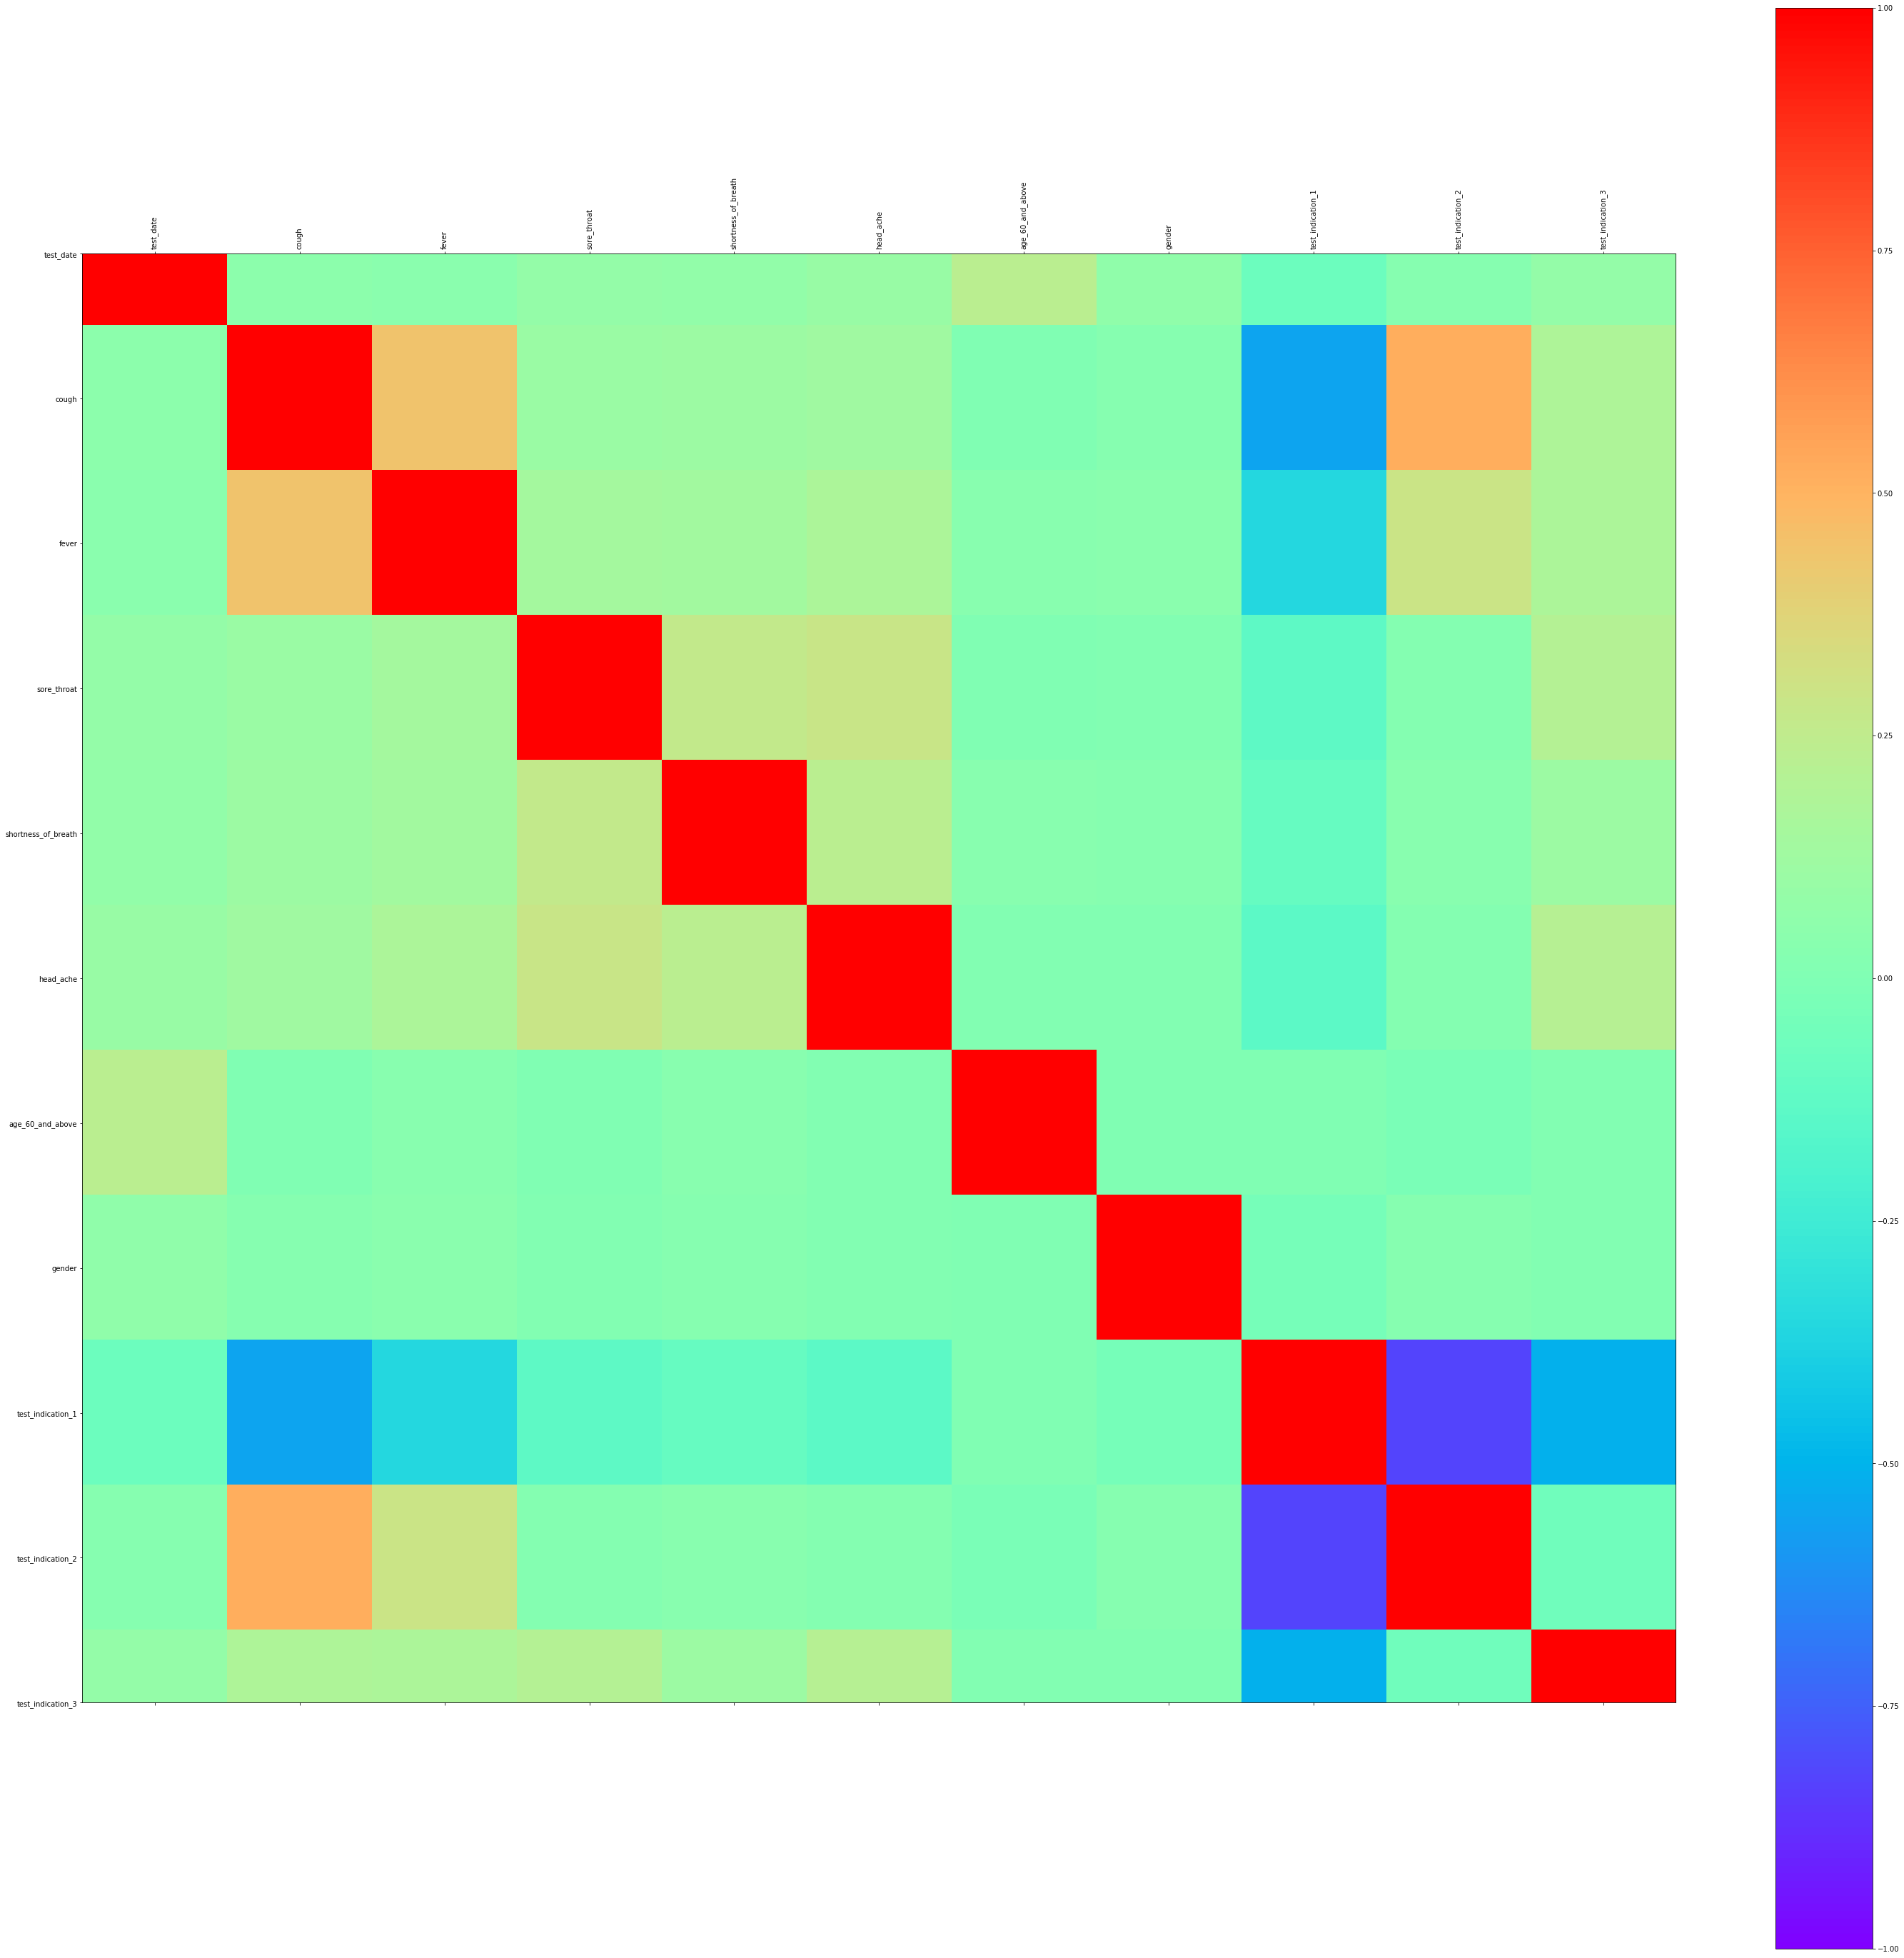

Running corr_matrix variable selection: 

Train accuracy: 0.8473611327820253 

Test accuracy: 0.7470901224224387 

Best parameters: {'corr_matrix__threshold': 0.7} 

Confusion matrix: 
               Predicted negative  Predicted positive
Real negative                3741                  49
Real positive                 104                 107


Running t_test variable selection: 

Train accuracy: 0.8473611327820253 

Test accuracy: 0.7494597906688842 

Best parameters: {'t_test__k': 6, 't_test__percentil': 20, 't_test__selection_type': 'Kbest'} 

Confusion matrix: 
               Predicted negative  Predicted positive
Real negative                3741                  49
Real positive                 103                 108


Running SelectKBest variable selection: 

Train accuracy: 0.8020947105632704 

Test accuracy: 0.7998824544510998 

Best parameters: {'SelectKBest__k': 5, 'SelectKBest__score_func': <function chi2 at 0x000002ADBDAB5048>} 

Confusion matrix: 
               Predic

In [6]:
vs.plot_correlation_matrix(X)
results_selection = vs.test_selection(X_train, X_test, y_train, y_test, verbose=True)

### Wrapper

In [7]:
results_selection = vs.test_selection_wrapper(X_train, X_test, y_train, y_test, results_selection, verbose=True)

Train accuracy: 0.7770225464190982 

Test accuracy: 0.7765815503507609 

Best parameters: 2 

Confusion matrix: 
               Predicted negative  Predicted positive
Real negative                3749                  41
Real positive                  92                 119


test_selection_wrapper took 0.44700050354003906[s] to execute.



### PCA

Train accuracy: 84.73611327820252 

Test accuracy: 75.89384636546662 

Best parameters: 8 

Confusion matrix: 
               Predicted negative  Predicted positive
Real negative                3741                  49
Real positive                  99                 112


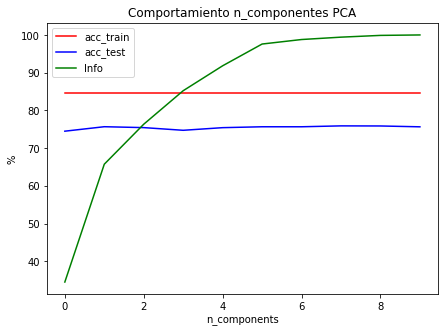



test_selection_PCA took 0.411998987197876[s] to execute.



In [8]:
results_selection = vs.test_selection_PCA(X_train, X_test, y_train, y_test, results_selection, verbose=True)

Una vez probados estos métodos y utilizando la métrica anteriomente mencionada para medir el rendimiento de cada uno de ellos, observamos el método que por el momento máximizaba la precisión en test era el SelectKBest utilizando como seleción de variables Chi2 y elijiendo 5 variables, las cuales fueron: fiebre, dificultad al respirar, contacto con positivo → Si, dolor de cabeza y dolor de garganta. Procedimos entonces a transformar nuestros conjuntos de train y test y continuar con el proceso

In [8]:
selection_method = feature_selection.SelectKBest(feature_selection.chi2, k=5).fit(X_train, y_train)

X_train_selected = selection_method.transform(X_train)
X_test_selected = selection_method.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Selección de instancias

Para la selección de instancias también se probaron varios métodos: sin selección, CNN, RNN y RMHC. Al tratarse de un dataset tan desbalanceado no podíamos aplicar las técnicas de selección de instancias al pie de la letra ya que podía darse el caso en que todas las instancias de la clase postivisa se eliminasen al tratarse solo del 5% del dataset por lo que tuvimos que modificar ligeramente estos métodos. En CNN y en con siguiente RNN ya que RNN parte de CNN lo que hicimos fue comenzar con todas las intancias de la clase positiva seleccionadas para que estas no puediesen ser descartadas y a partir de ahí realizar el método con normalidad. Para RMHC sin embargo lo que hicimos fue incluir todas las intancias positivas en seleccionadas y de forma aleatoria elegir el mismo número de instancias negativas e incluirlas en seleccionadad y partiendo de ese punto ejecutar el método con normalidad, de esto modo nos asegurabamos una vez más que no eliminabamos ninguna instancia positiva.

In [9]:
metodos = (i_sel.sin_seleccion, i_sel.CNN, i_sel.RNN, i_sel.RMHC)
nMetodos = len(metodos)

S = np.zeros((nMetodos, X_train_selected.shape[0]))
acc_train = np.zeros(nMetodos)
acc_test = np.zeros(nMetodos)
red = np.zeros(nMetodos)
nRules = np.zeros(nMetodos)

clasificador = tree.DecisionTreeClassifier()

for i, metodo in enumerate(metodos):
    S[i, :], acc_train[i], acc_test[i], red[i], nRules[i] = i_sel.ejecutaMetodoIS(metodo, clasificador, X_train_selected, y_train, X_test_selected, y_test, verbose=True)

Ejecutando sin_seleccion...
Resultados sin_seleccion python
Precisión en train: 0.8020947105632704
Precisión en test: 0.7998824544510998
Reducción sin_seleccion: 9333 de 9333
Reducción: 0.00%
Número de reglas: 43
Confusion matrix train: 
               Predicted negative  Predicted positive
Real negative                8730                 110
Real positive                 189                 304
Confusion matrix test: 
               Predicted negative  Predicted positive
Real negative                3746                  44
Real positive                  82                 129
ejecutaMetodoIS took 0.01900005340576172[s] to execute.

Ejecutando CNN...
CNN, fin de iteración, fallados: 360, ejemplos en S: 854
CNN, fin de iteración, fallados: 0, ejemplos en S: 854
Resultados CNN python
Precisión en train: 0.8506670307380246
Precisión en test: 0.8266803386312196
Reducción CNN: 854 de 9333
Reducción: 90.85%
Número de reglas: 37
Confusion matrix train: 
               Predicted negative  Pr

Una vez ejecutados los métodos de selección de instancias, observamos los resultados y comprobamos que aplicando el método CNN de reducción de variables mejorabamos notablemente la precisión especialmente mejoraba la sensibilidad la cual mejoraba más de 10 puntos de media. La reducción supuso que se eliminaran el 90.98% de instancias para entrenar el modelo. Ya aplicadas tanto la selección de instancias como la selección de variables era el momento de empezar a buscar el mejor modelo que maximizase nuestra métrcia probrando numeras combinaciones de parametros para distintos modelos.

### Arbol de decisión

Durante toas las fases de selección previas al entrenamiento del modelo, hemos estado clasificando mediante un árbol de decisión.
Veamos ahora como mejoran los resultados cambiando los hiperparámetros de este clasificador.

DecisionTreeClassifier: 
Best params: {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Train: 0.8450908878140115
Test: 0.8206886418487164
Confusion matrix train:                Predicted negative  Predicted positive
Real negative                7715                1125
Real positive                  90                 403
Confusion matrix test:                Predicted negative  Predicted positive
Real negative                3293                 497
Real positive                  48                 163


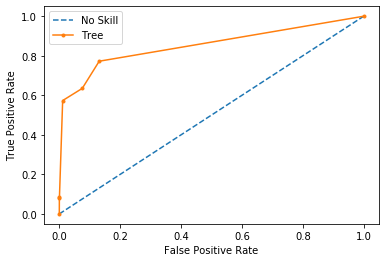

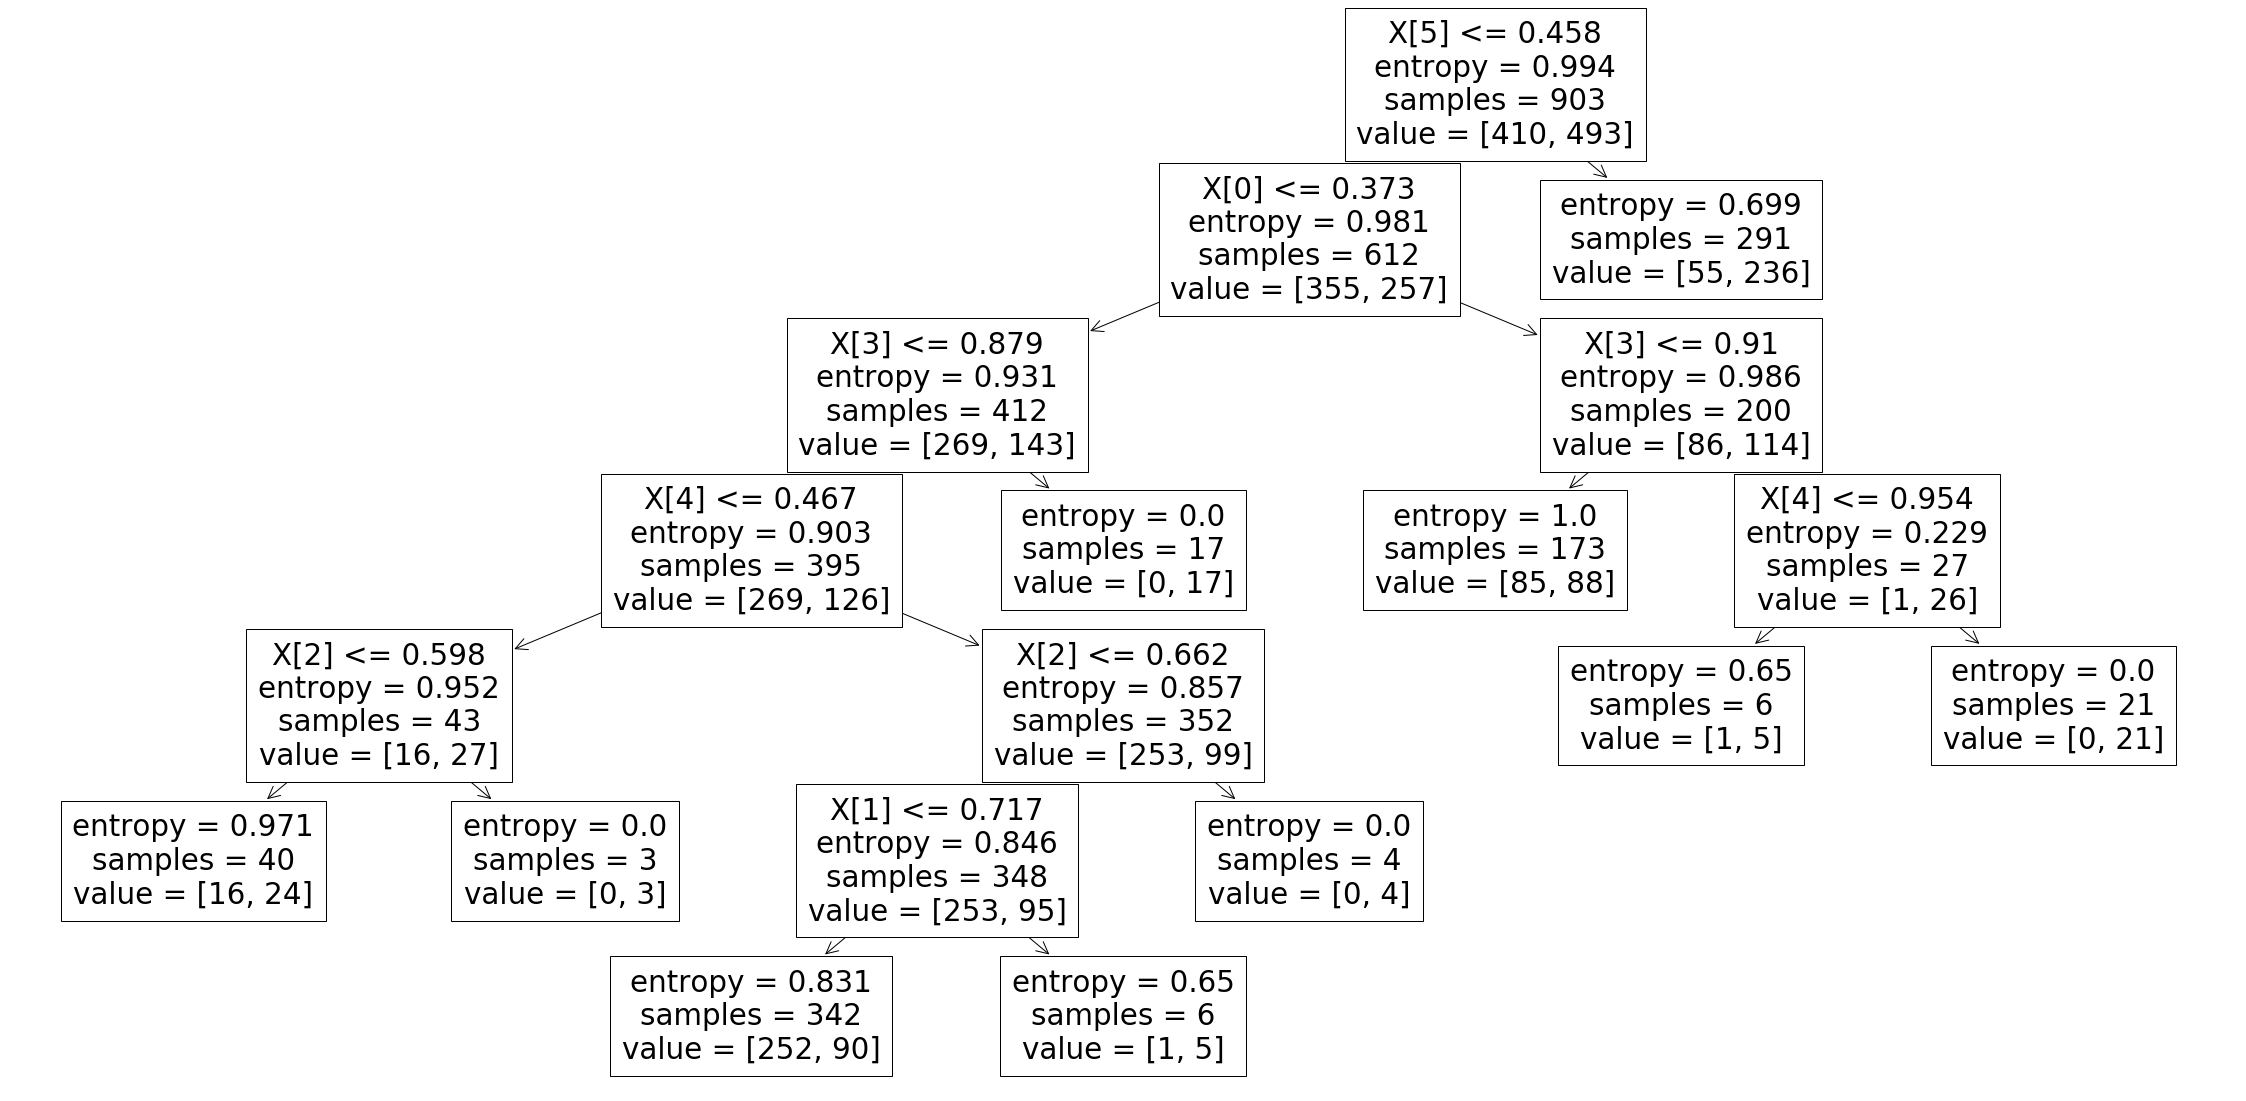



train_tree took 23.692753791809082[s] to execute.



In [7]:
np.random.seed(12)
tree = cm.train_tree(X_train_selected, X_test_selected, y_train, y_test, S[1], verbose=True)

Vemos como después de encontrar los mejores hiperparámetros para el modelo, conseguimos los siguientes resultados:

- Aumento de la sensibilidad de un 72% a un 77%
- A cambio del aumento en la sensibilidad, reducimos la especifidad de un 89% a un 87%

Aún que hayamos reducido la especificad un 2%, el modelo ha mejorado, ya que buscamos priorizar el predecir como positivos aquellos que son positivos frente a predecir como positivmos a alguien que no lo es.

### Bosque

In [10]:
forest = cm.train_forest(X_train_selected, X_test_selected, y_train, y_test, S[1], verbose=True)

RandomForestClassifier: 
Best params: {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'max_leaf_nodes': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Train: 0.8020947105632704
Test: 0.7998824544510998
Confusion matrix train: 
                Predicted negative  Predicted positive
Real negative                8730                 110
Real positive                 189                 304
Confusion matrix test: 
                Predicted negative  Predicted positive
Real negative                3746                  44
Real positive                  82                 129


train_forest took 562.7166666984558[s] to execute.



### Adaboost

In [11]:
adaboost_scikit = cm.train_adaboost(X_train_selected, X_test_selected, y_train, y_test, S[1], verbose=True)

AdaboostClasifier: 
Best params: {'base_estimator__ccp_alpha': 0.001, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'base_estimator__max_features': 'sqrt', 'base_estimator__max_leaf_nodes': 8, 'base_estimator__min_samples_leaf': 10, 'base_estimator__min_samples_split': 2, 'learning_rate': 1, 'n_estimators': 100}
Train: 0.8506670307380246
Test: 0.8266803386312196
Confusion matrix train: 
                Predicted negative  Predicted positive
Real negative                8226                 614
Real positive                 113                 380
Confusion matrix test: 
                Predicted negative  Predicted positive
Real negative                3536                 254
Real positive                  59                 152


train_adaboost took 8854.99958205223[s] to execute.



Después de ver los resultados de los 3 clasificadores, nos quedamos con el arbol de decisión.
No es un modelo perfecto, pero desde luego que nos acercamos bastamte a la sensibilidad y especificad de las PCR, rondando los 80% y 97% respectivamente.

Nos queda tiempo para hacer posible un modelo semejante que podamos utilizar de una manera más fiable para con el control de la pandemia, pero es una buena aproximación a lo que podría ser.